In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**TAXI TRIP FARE PREDICTION**




In [ ]:

# Importing library
import pandas as pd

In [ ]:

def load_taxi_fare(TAXI_PATH):
 return pd.read_csv(TAXI_PATH)

taxi = load_taxi_fare("/content/drive/MyDrive/taxi_fare/train.csv")
taxi.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


In [ ]:
taxi.info()

# check total_bedrooms as we  can see that it has missing values
# check the ocean_proximity. Its in object so it must be categorical value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


In [ ]:
taxi["distance_traveled"].value_counts()

2.25     1954
2.09     1761
1.93     1684
1.77     1603
1.61     1598
         ... 
47.52       1
85.33       1
27.46       1
59.80       1
33.72       1
Name: distance_traveled, Length: 2463, dtype: int64

In [ ]:

taxi.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000
mean,1173.181478,5.054431,1.292808,99.623431,13.030824,15.136829,127.791084,0.280523
std,4775.653621,125.217419,0.930754,85.602702,20.367764,12.553436,98.797374,0.449256
min,0.000000,0.020000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000
25%,446.000000,1.950000,1.000000,52.500000,0.000000,6.000000,70.200000,0.000000
50%,707.000000,3.200000,1.000000,75.000000,9.000000,9.750000,101.700000,0.000000
75%,1098.000000,5.730000,1.000000,116.250000,20.000000,26.450000,152.250000,1.000000
max,86387.000000,57283.910000,9.000000,4466.250000,2500.000000,435.000000,4472.250000,1.000000


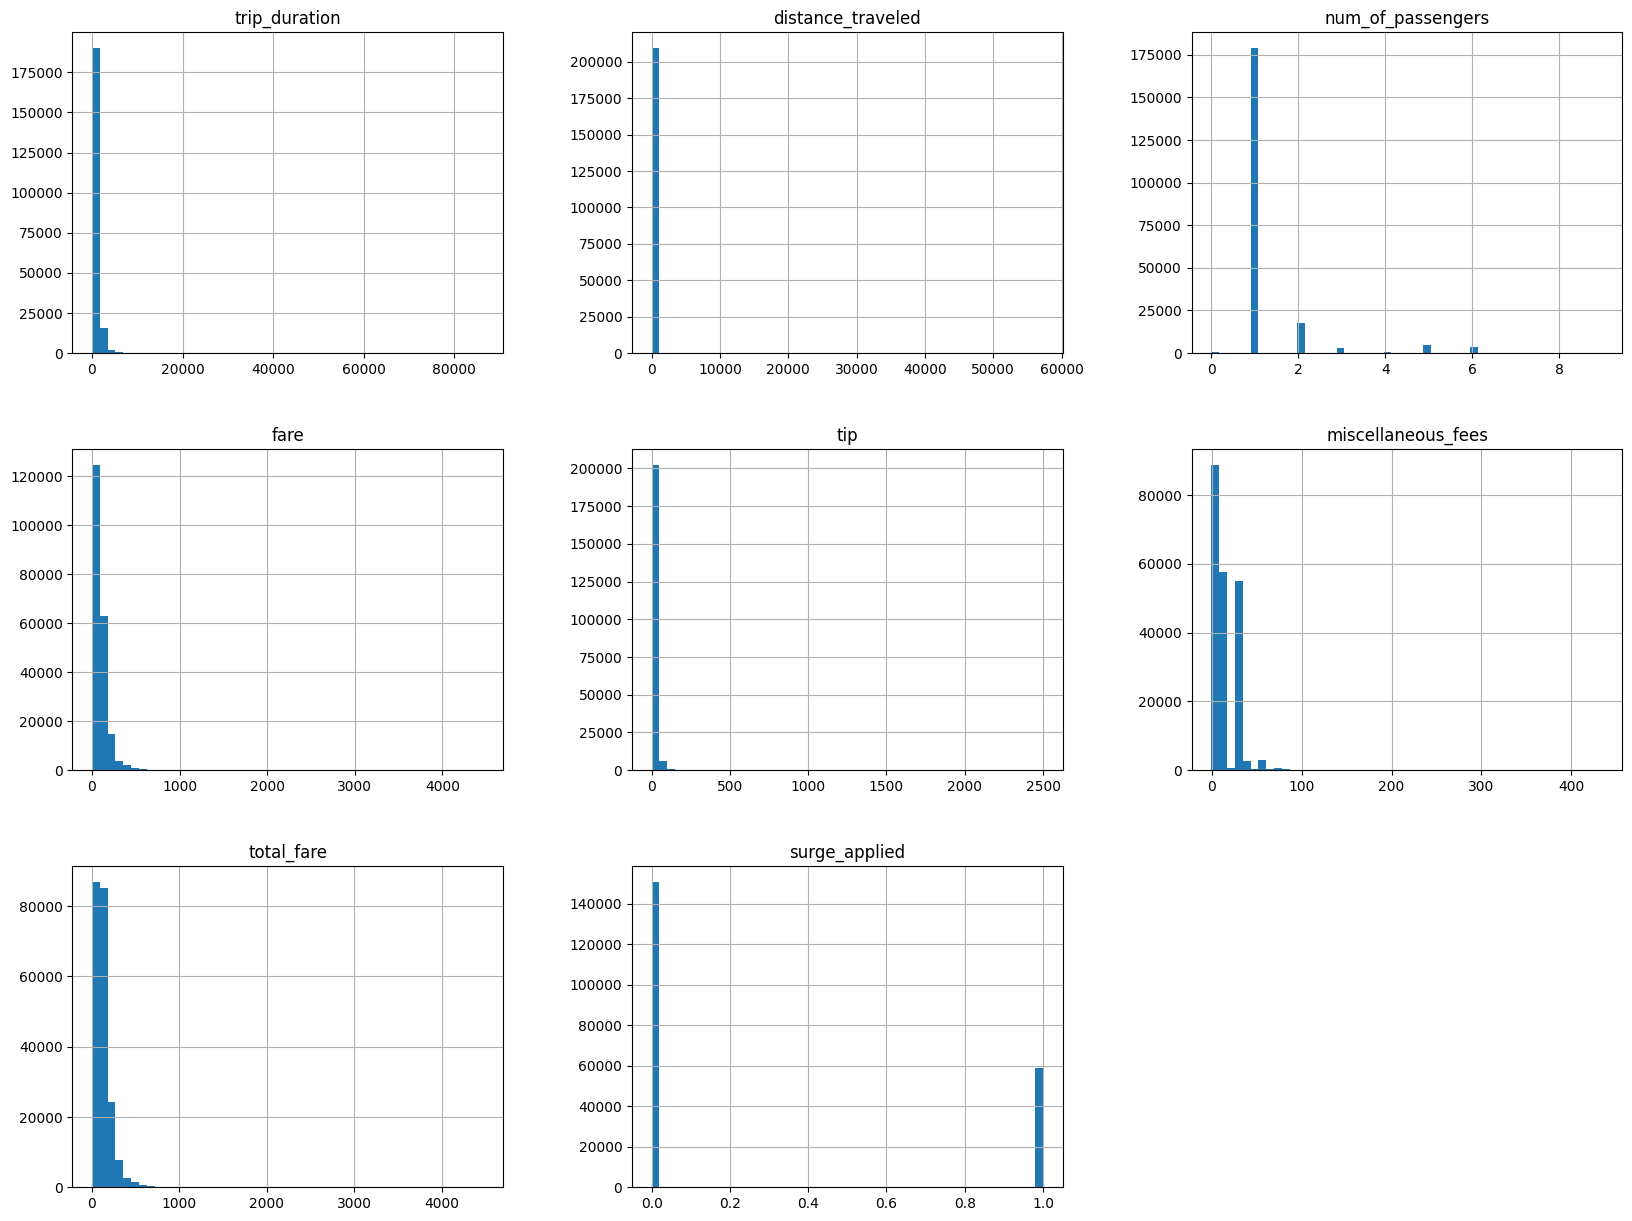

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
taxi.hist(bins=50, figsize=(20,15))
plt.show()

**Split Dataset into Train and Test.**

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(taxi, test_size=0.2, random_state=42)

In [ ]:


# why this may be some expert can suggest that distance traveled can be most important features
import numpy as np
taxi["trip_duration"] = pd.cut(taxi["distance_traveled"],
 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
 labels=[1, 2, 3, 4, 5])

<Axes: >

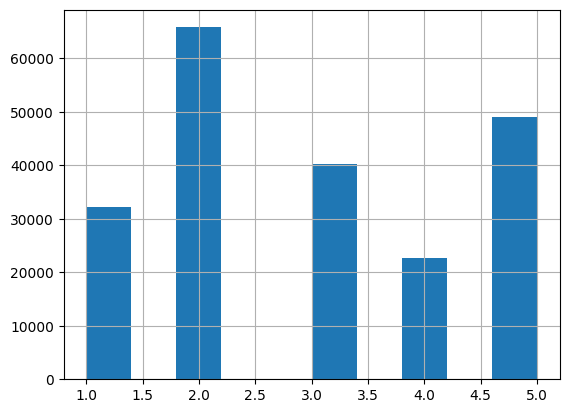

In [ ]:

taxi["trip_duration"].hist()

**Startified Sampling**

In [ ]:
# equal distribution of the dataset in train and test
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(taxi, taxi["trip_duration"]):
 strat_train_set = taxi.loc[train_index]
 strat_test_set = taxi.loc[test_index]

In [ ]:

strat_test_set["trip_duration"].value_counts() / len(strat_test_set)

2    0.313700
5    0.233361
3    0.191940
1    0.153118
4    0.107881
Name: trip_duration, dtype: float64

In [ ]:
for set_ in (strat_train_set, strat_test_set):
 set_.drop("trip_duration", axis=1, inplace=True)

In [ ]:
taxi = strat_train_set.copy()

In [ ]:
corr_matrix = taxi.corr()

# check the correlation in descending order
corr_matrix["distance_traveled"].sort_values(ascending=False)

distance_traveled     1.000000
total_fare            0.033521
fare                  0.032639
miscellaneous_fees    0.020853
tip                   0.012770
surge_applied         0.004650
num_of_passengers    -0.000437
Name: distance_traveled, dtype: float64

In [ ]:

# creating own features and  check whether its correlation
taxi["trip_duration"] = taxi["num_of_passengers"]/taxi["fare"]
taxi["miscellaneous_fees"] = taxi["fare"]/taxi["num_of_passengers"]
taxi["total_fare"]=taxi["distance_traveled"]/taxi["fare"]


# checking over the correlation of median taxi price with other features
corr_matrix = taxi.corr()
corr_matrix["distance_traveled"].sort_values(ascending=False)


distance_traveled     1.000000
total_fare            0.755339
fare                  0.032639
miscellaneous_fees    0.031331
tip                   0.012770
surge_applied         0.004650
num_of_passengers    -0.000437
trip_duration        -0.003410
Name: distance_traveled, dtype: float64

**Prepare Dataset for model.**

In [58]:

# separate it for the input X and label Y
taxi = strat_train_set.drop("distance_traveled", axis=1)
taxi_labels = strat_train_set["distance_traveled"].copy()


Data cleaning

In [ ]:
# taxi.dropna(subset=["total_fare"]) # option 1
# taxi.drop("total_fare", axis=1) # option 2
# median = taxi["total_fare"].median() # option 3
# taxi["total_fare"].fillna(median, inplace=True)


from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
#drop the categorical value
taxi_num = taxi.drop("total_fare", axis=1)
imputer.fit(taxi_num)

print(imputer.statistics_)
print(taxi_num.median().values)

[ 1.   75.    9.    9.75  0.  ]
[ 1.   75.    9.    9.75  0.  ]


In [ ]:

X = imputer.transform(taxi_num)
taxi_tr = pd.DataFrame(X, columns=taxi_num.columns,
 index=taxi_num.index)

In [ ]:
taxi_tr

,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
148072,1.0,37.50,0.0,9.75,0.0
149907,1.0,75.00,0.0,6.00,0.0
173686,1.0,93.75,0.0,9.75,0.0
43181,1.0,67.50,1.0,5.60,0.0
195681,1.0,146.25,8.0,5.50,0.0
...,...,...,...,...,...
27065,1.0,22.50,0.0,6.00,0.0
194118,1.0,101.25,23.0,26.65,1.0
199688,1.0,22.50,0.0,6.00,0.0
168868,1.0,86.25,23.0,26.20,1.0


Handling text and categorical attributes.

In [ ]:

taxi_cat = taxi[["total_fare"]]
taxi_cat.head(10)

,total_fare
148072,47.25
149907,81.00
173686,103.50
43181,74.10
195681,159.75
145816,92.25
41838,36.00
151543,101.25
27621,76.05
48342,96.00


In [ ]:

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
taxi_cat_encoded = ordinal_encoder.fit_transform(taxi_cat)
taxi_cat_encoded[:10]

array([[  94.],
       [ 360.],
       [ 559.],
       [ 295.],
       [1041.],
       [ 456.],
       [  40.],
       [ 542.],
       [ 315.],
       [ 494.]])

In [ ]:

taxi_num

,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
148072,1.0,37.50,0,9.75,0
149907,1.0,75.00,0,6.00,0
173686,1.0,93.75,0,9.75,0
43181,1.0,67.50,1,5.60,0
195681,1.0,146.25,8,5.50,0
...,...,...,...,...,...
27065,1.0,22.50,0,6.00,0
194118,1.0,101.25,23,26.65,1
199688,1.0,22.50,0,6.00,0
168868,1.0,86.25,23,26.20,1


Transformation pipeline

In [ ]:

list(taxi_num)

['num_of_passengers', 'fare', 'tip', 'miscellaneous_fees', 'surge_applied']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', StandardScaler()),
])



taxi_num_tr = num_pipeline.fit_transform(taxi_num)

In [ ]:

taxi_num_tr

array([[-0.31418622, -0.72372387, -0.65860637, -0.42959901, -0.62391717],
       [-0.31418622, -0.28698997, -0.65860637, -0.72868219, -0.62391717],
       [-0.31418622, -0.06862302, -0.65860637, -0.42959901, -0.62391717],
       ...,
       [-0.31418622, -0.89841743, -0.65860637, -0.72868219, -0.62391717],
       [-0.31418622, -0.1559698 ,  0.50408971,  0.88237918,  1.60277685],
       [ 0.75928443, -0.37433675, -0.65860637, -0.42959901, -0.62391717]])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
num_attribs = list(taxi_num)
cat_attribs = ["total_fare"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])


taxi_prepared = full_pipeline.fit_transform(taxi)

**Training and evaluating on the training set.**

In [ ]:

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(taxi_prepared, taxi_labels)

LinearRegression()

In [59]:

some_data = taxi.iloc[:5]
some_labels = taxi_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))


Predictions: [2.27815763 2.16391472 5.50996706 1.6311366  6.96216365]
Labels: [1.29, 3.17, 4.46, 2.85, 7.08]


In [ ]:
from sklearn.metrics import mean_squared_error
taxi_predictions = lin_reg.predict(taxi_prepared)
lin_mse = mean_squared_error(taxi_labels, taxi_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

121.07629037991524

In [ ]:

# Decision tree
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(taxi_prepared, taxi_labels)

DecisionTreeRegressor()

In [60]:

# Overfit problem

taxi_predictions = tree_reg.predict(taxi_prepared)
tree_mse = mean_squared_error(taxi_labels, taxi_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


1.4548123044655317

**Cross-Validation**

In [ ]:
# Better Evaluation Using Cross-Validation
# k fold cross validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, taxi_prepared, taxi_labels,
 scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [  2.1884791    2.80287449   2.59056668 442.21548448   2.10084624
   9.05170311   2.03201921   2.13063298   2.22021146   2.37746479]
Mean: 46.971028253690136
Standard deviation: 131.7636951526194


In [ ]:

lin_scores = cross_val_score(lin_reg, taxi_prepared, taxi_labels,
            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

In [ ]:

 display_scores(lin_rmse_scores)

Scores: [  5.00258067 147.36661943   4.99442579 442.21038373   4.76451099
   9.86392246   4.72628481 147.38468373   4.57209948   5.07024692]
Mean: 77.59557580202947
Standard deviation: 133.79737368779175


In [ ]:

# Random forest
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(taxi_prepared, taxi_labels)

RandomForestRegressor()

In [ ]:
# Overfit problem
# without cross validation
taxi_predictions = forest_reg.predict(taxi_prepared)
random_forest_mse = mean_squared_error(taxi_labels, taxi_predictions)
random_forest_rmse = np.sqrt(random_forest_mse)
random_forest_rmse

54.619564866677145

In [ ]:
# with cross validation
random_forest_scores = cross_val_score(forest_reg, taxi_prepared, taxi_labels,
            scoring="neg_mean_squared_error", cv=10)
random_forest_rmse_scores = np.sqrt(-random_forest_scores)

In [43]:


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(random_forest_rmse_scores)

Scores: [  1.96153199  44.2888818    2.30361504 442.18936372   2.02175837
   9.01126612   1.92890663  31.02588634   1.92471186   2.15333509]
Mean: 53.88092569571014
Standard deviation: 130.20388213959336


**Grid Search**

In [44]:

from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(taxi_prepared, taxi_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:

grid_search.best_params_

{'max_features': 4, 'n_estimators': 10}

In [46]:

grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=10)

In [47]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

147.45636985350035 {'max_features': 2, 'n_estimators': 3}
140.57776882712884 {'max_features': 2, 'n_estimators': 10}
140.96823650199417 {'max_features': 2, 'n_estimators': 30}
154.64730585251672 {'max_features': 4, 'n_estimators': 3}
139.8824795804939 {'max_features': 4, 'n_estimators': 10}
140.7380235166426 {'max_features': 4, 'n_estimators': 30}
161.51428747880462 {'max_features': 6, 'n_estimators': 3}
140.58242782597148 {'max_features': 6, 'n_estimators': 10}
141.4281667086256 {'max_features': 6, 'n_estimators': 30}
147.44356808118434 {'max_features': 8, 'n_estimators': 3}
148.02826953536024 {'max_features': 8, 'n_estimators': 10}
143.93772167263225 {'max_features': 8, 'n_estimators': 30}
147.4470069547135 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
140.57802598088037 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
147.4452819072561 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
141.95524015574264 {'bootstrap': False, 'max_features': 3, 'n_esti

In [48]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([4.12868732e-03, 2.36088919e-01, 1.22728606e-01, ...,
       2.12828445e-06, 4.28776977e-04, 3.17048568e-06])

In [49]:
final_model = grid_search.best_estimator_

In [50]:

final_model

RandomForestRegressor(max_features=4, n_estimators=10)

**Test model in testing set.**

In [ ]:

x_test = strat_test_set.drop("distance_traveled", axis=1)
y_test = strat_test_set["distance_traveled"].copy()
X_test_prepared = full_pipeline.transform(x_test)

In [ ]:

final_predictions = final_model.predict(x_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

**Save Model**

In [57]:

import joblib
joblib.dump(final_model, "my_model.pkl")

['my_model.pkl']